In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path.append('../../module/')

import keras2
from keras2.models import Model
from keras2.layers import concatenate, Dense, Input, Flatten
from keras2.optimizers import Adam
from util import moving_average, dlqr, discretized_system, lqr
import gym2
from rl2.agents import safeDDPGAgent
from rl2.memory import SequentialMemory

Using TensorFlow backend.
Using TensorFlow backend.


In [2]:
# GymのPendulum環境を作成
dt = 0.005
env = gym2.make("Pendulum-v1", dt)
clip = 10.
env.max_torque, max_torque = clip, clip
env.action_space.high, env.action_space.low = max_torque, -max_torque
control_interval = 1

# 取りうる”打ち手”のアクション数と値の定義
nb_actios = 2
ACT_ID_TO_VALUE = {0: [-1], 1: [+1]}

In [3]:
def actor_net(a_shape, s_shape):
    action_input = Input(shape=(1,)+s_shape)
    x = Flatten()(action_input)
    x = Dense(16, activation="relu")(x)
    x = Dense(16, activation="relu")(x)
    x = Dense(1, activation="multiple_tanh")(x)
    actor = Model(inputs=action_input, outputs=x)
    return actor

def critic_net(a_shape , s_shape):
    action_input = Input(a_shape)
    observation_input = Input(shape=(1,)+s_shape)
    flattened_observation = Flatten()(observation_input)
    x = concatenate([action_input, flattened_observation])
    x = Dense(16, activation="relu")(x)
    x = Dense(16, activation="relu")(x)
    x = Dense(1, activation="linear")(x)
    critic = Model(inputs=[action_input, observation_input], outputs=x)
    return (critic, action_input)

In [4]:
def agent(a_shape, s_shape):
    actor = actor_net(a_shape, s_shape)
    critic,  critic_action_input = critic_net(a_shape, s_shape)
    memory = SequentialMemory(limit = 50000, window_length = 1)
    agent = safeDDPGAgent(
        a_shape[0],
        actor,
        critic,
        critic_action_input,
        memory,
        clip_com = 0.01
    )
    return agent

In [5]:
#safe learning
step = 100000
episode_step = int(2000 * 0.005 / (dt * control_interval)) # 入力が加えられる回数を2000(dt=0.005)にする
a = agent((1,), (2,))
a.compile(Adam(lr=0.001, clipnorm=1.), metrics=["mae"])
# a.load_weights('../../learned_models_com/2output_tau1_opt.h5')
out = a.fit(env, nb_steps=step, visualize=0, verbose=1, nb_max_episode_steps=episode_step, action_repetition=control_interval)

episode_rewards = out.history['episode_reward']







Training for 100000 steps ...
Interval 1 (0 steps performed)
10000/10000 [==============================] - 75s 7ms/step - reward: -0.5081
5 episodes - episode_reward: -1016.282 [-1166.143, -875.581] - loss: 0.006 - mean_absolute_error: 0.075 - mean_q: -0.035

Interval 2 (10000 steps performed)
10000/10000 [==============================] - 79s 8ms/step - reward: -0.4472
5 episodes - episode_reward: -894.467 [-920.934, -881.959] - loss: 0.013 - mean_absolute_error: 0.082 - mean_q: -3.939

Interval 3 (20000 steps performed)
10000/10000 [==============================] - 77s 8ms/step - reward: -0.4468
5 episodes - episode_reward: -893.553 [-903.204, -886.765] - loss: 0.034 - mean_absolute_error: 0.105 - mean_q: -7.513

Interval 4 (30000 steps performed)
10000/10000 [==============================] - 73s 7ms/step - reward: -0.4723
5 episodes - episode_reward: -944.665 [-972.266, -927.229] - loss: 0.063 - mean_absolute_error: 0.113 - mean_q: -10.644

Interval 5 (40000 steps performed

In [6]:
a.test(env, visualize=0, nb_max_episode_steps=episode_step, action_repetition=control_interval)

Testing for 1 episodes ...
Episode 1: reward: -995.696, steps: 2000


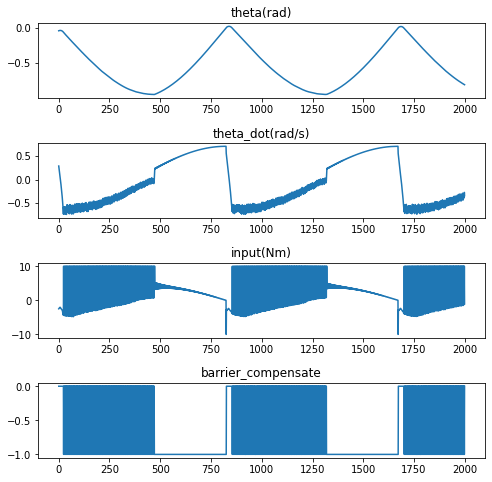

In [7]:
titles = ['theta(rad)', 'theta_dot(rad/s)', 'input(Nm)', 'barrier_compensate'] 
history = a.data_log[0]
x_axis = range(history.shape[0])
plt.figure(figsize=(8,8))
plt.subplots_adjust(wspace=0.4, hspace=0.6)
for i in range(history.shape[1]):
    data = history[:,i]
    plt.subplot(history.shape[1],1,i+1)
    plt.title(titles[i])
    plt.plot(x_axis, data)
plt.show()

(50,)


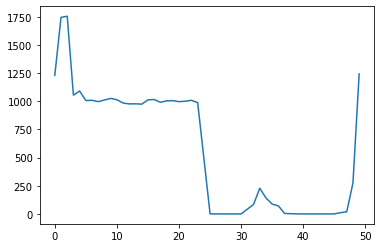

In [12]:
b = np.array(out.history['episode_barrier'])
print(b.shape)
plt.plot(range(b.shape[0]), b)